In [ ]:
# !pip install pretrainedmodels

In [1]:
import warnings
warnings.filterwarnings('ignore')

from fastai.vision import *
from fastai.callbacks import *
import pretrainedmodels

In [2]:
data_path = Path('./chest_xray').absolute()
model_path = Path('./model').absolute()

In [3]:
stats = ([0.48746821, 0.48746821, 0.48746821], [0.24557937, 0.24557937, 0.24557937])

def valid_func(o):
    return 'test' in str(o)

def label_func(o):
    name = o.name
    if 'virus' in name:
        return 'virus'
    if 'bacteria' in name:
        return 'bacteria'
    return 'normal'

data = (ImageList.from_folder(data_path)
        .split_by_valid_func(valid_func)
        .label_from_func(label_func)
        .transform(get_transforms(), size=456)
        .databunch(bs=32)
        .normalize(stats)
        )

data, data.classes

(ImageDataBunch;
 
 Train: LabelList (5232 items)
 x: ImageList
 Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456)
 y: CategoryList
 normal,normal,normal,normal,normal
 Path: /media/sm2/data/pneumonia/chest_xray;
 
 Valid: LabelList (624 items)
 x: ImageList
 Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456)
 y: CategoryList
 normal,normal,normal,normal,normal
 Path: /media/sm2/data/pneumonia/chest_xray;
 
 Test: None,
 ['bacteria', 'normal', 'virus'])

In [4]:
# def resnext101_64x4d(pretrained=False):
#     pretrained = 'imagenet' if pretrained else None
#     model = pretrainedmodels.resnext101_64x4d(pretrained=pretrained)
#     all_layers = list(model.children())
#     return nn.Sequential(*all_layers[0], *all_layers[1:])

In [4]:
def resnext101_32x4d(pretrained=False):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.resnext101_64x4d(pretrained=pretrained)
    all_layers = list(model.children())
    return nn.Sequential(*all_layers[0], *all_layers[1:])

In [5]:
learn = cnn_learner(data, 
                    resnext101_32x4d,
                    cut=-2, 
                    split_on=lambda m: (m[0][6], m[1]),
                    bn_wd=False,
                    metrics=error_rate,
                    loss_func=LabelSmoothingCrossEntropy(),
                    callback_fns=[BnFreeze,
                                  partial(SaveModelCallback, monitor='error_rate', name='best_error')
                                 ],
                    model_dir=model_path, 
                    ).to_fp16()

In [6]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.130671,0.865772,0.241987,02:27
1,0.785916,0.700737,0.201923,02:17
2,0.697668,0.644492,0.179487,02:19
3,0.656029,0.624531,0.165064,02:17
4,0.616894,0.630052,0.158654,02:19


Better model found at epoch 0 with error_rate value: 0.2419871836900711.
Better model found at epoch 1 with error_rate value: 0.20192307233810425.
Better model found at epoch 2 with error_rate value: 0.1794871836900711.
Better model found at epoch 3 with error_rate value: 0.16506409645080566.
Better model found at epoch 4 with error_rate value: 0.1586538404226303.


epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


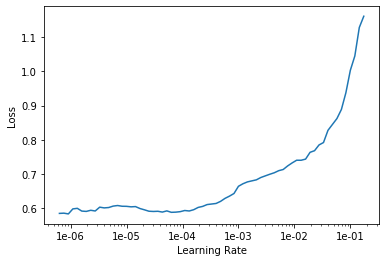

In [7]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [8]:
lr = 1e-4
learn.fit_one_cycle(5, slice(lr/30, lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.607698,0.609091,0.155449,02:57
1,0.611098,0.596881,0.145833,02:59
2,0.586244,0.601557,0.152244,02:59
3,0.540065,0.601954,0.150641,02:58
4,0.529686,0.608531,0.157051,02:59


Better model found at epoch 0 with error_rate value: 0.15544871985912323.
Better model found at epoch 1 with error_rate value: 0.1458333283662796.


epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


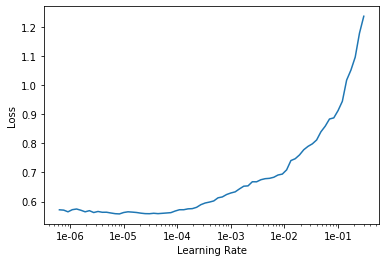

In [9]:
learn.lr_find()
learn.recorder.plot()

In [10]:
lr = 5e-5
learn.fit_one_cycle(25, slice(lr/30, lr), pct_start=0, final_div=1000)

epoch,train_loss,valid_loss,error_rate,time
0,0.563107,0.618781,0.149038,02:59
1,0.548004,0.620845,0.158654,02:59
2,0.538995,0.611488,0.153846,02:59
3,0.515200,0.594321,0.145833,02:58
4,0.514906,0.615843,0.163462,02:59
5,0.479651,0.653310,0.195513,02:58
6,0.472304,0.606853,0.171474,02:59
7,0.457378,0.637586,0.177885,03:00
8,0.442730,0.631211,0.185897,03:01
9,0.435919,0.616543,0.168269,02:59


Better model found at epoch 0 with error_rate value: 0.14903846383094788.
Better model found at epoch 3 with error_rate value: 0.1458333283662796.
